In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import tqdm
import pickle
import time

from swimAD2 import swimAD2 as ad2       # copy swimAD2.py to your working directory
import dwfconstants as dwfc

ad2.disconnect()            # close all instances before connecting
zoroku = ad2.connect(0)      # connect to first(0th) ad2, give it the name 'zoroku'

2.0 0.1875


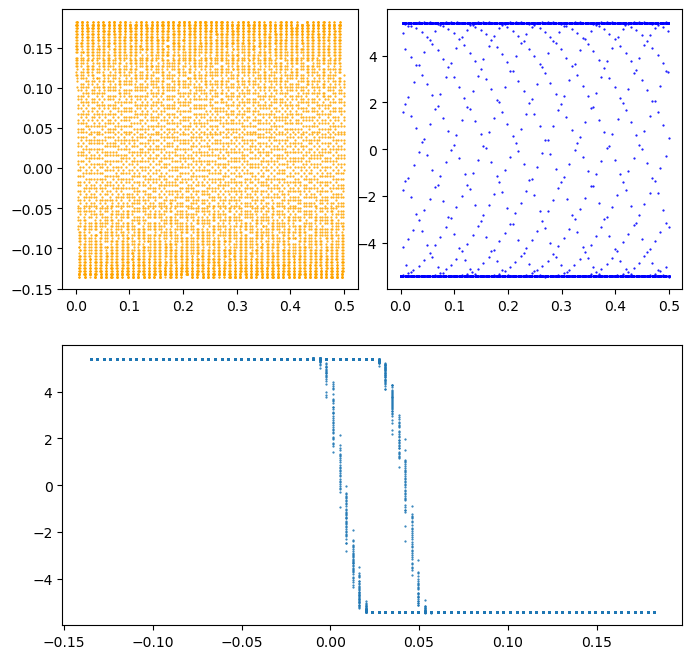

In [76]:
def sampling(time):
    hertz = 100e6
    size = time*hertz 
    if size <= 8192:
        return size,hertz
    else: 
        size = 8192
        hertz = size/time
        return size,hertz

fig = plt.figure(figsize=(8,8))
grid = gs.GridSpec(2,2,wspace=0.1,)

axs1 = plt.subplot(grid[0,0])
axs2 = plt.subplot(grid[0,1])
axs3 = plt.subplot(grid[1,:])

t_mes = 0.5
size,rate = sampling(t_mes)

R1 = 1000
R2 = 150
v_range = .25*5*R2/R1
print(1/t_mes,v_range)

ad2.config_wavegen(zoroku, 
            frequency=50/t_mes,
            amplitude=v_range,
            offset=0,
            channel = 0,
            signal_shape= dwfc.funcSine
            )

ad2.config_oscilloscope(zoroku,
    range0=23,
    range1=23,
    sample_rate = rate,
    sample_size= size,
    )

ad2.start_wavegen(zoroku,channel=0)
time.sleep(0.1)
T,Ch1,Ch2 = ad2.measure_oscilloscope(zoroku)
ad2.stop_wavegen(zoroku,channel=0)

axs1.scatter(T,Ch1,s=0.3,color="orange")
axs2.scatter(T,Ch2,s=0.3,color="blue")
axs3.scatter(Ch1,Ch2,s=0.3)

0.375
Data up to resistor 150 has been collected and saved.
0.55
Data up to resistor 220 has been collected and saved.
0.825
Data up to resistor 330 has been collected and saved.
1.175
Data up to resistor 470 has been collected and saved.
1.275
Data up to resistor 510 has been collected and saved.
2.0
Data up to resistor 800 has been collected and saved.
2.5
Data up to resistor 1000 has been collected and saved.
5.0
Data up to resistor 2000 has been collected and saved.
11.75
Data up to resistor 4700 has been collected and saved.


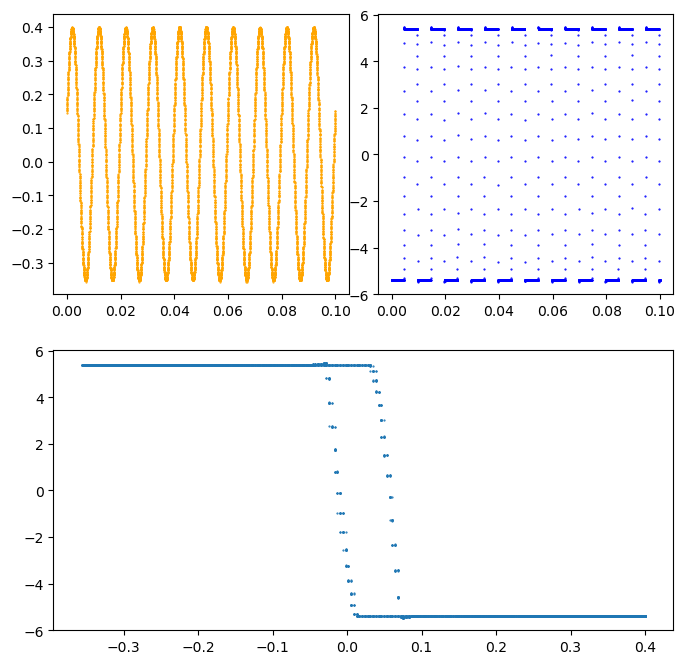

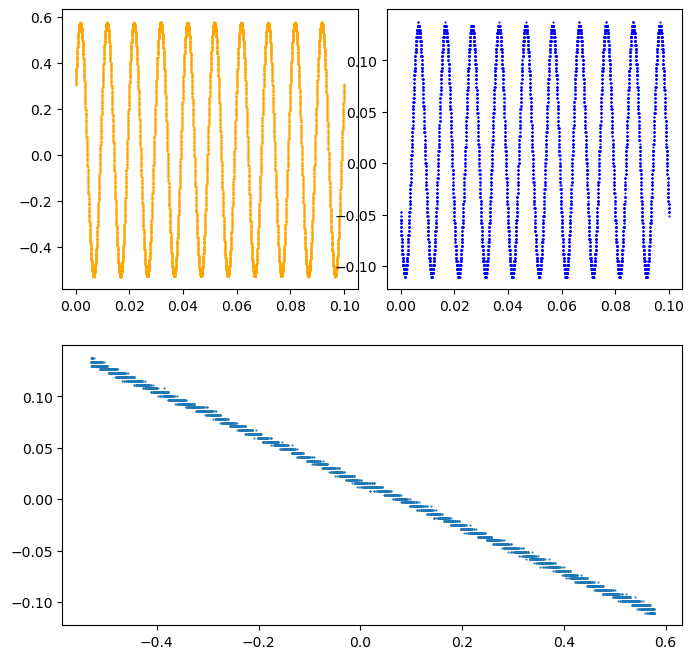

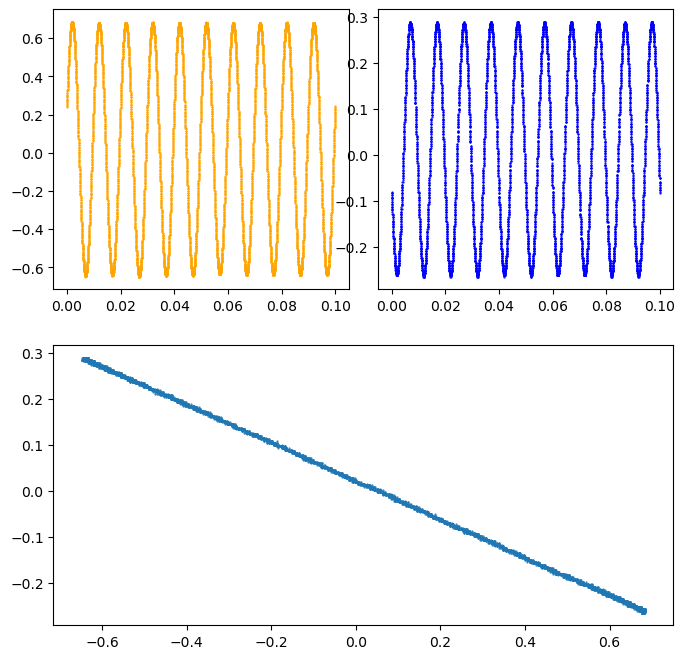

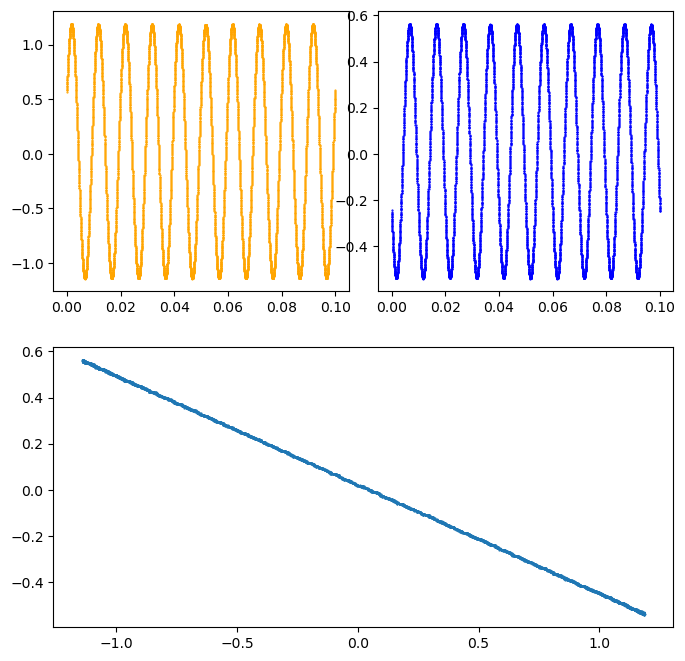

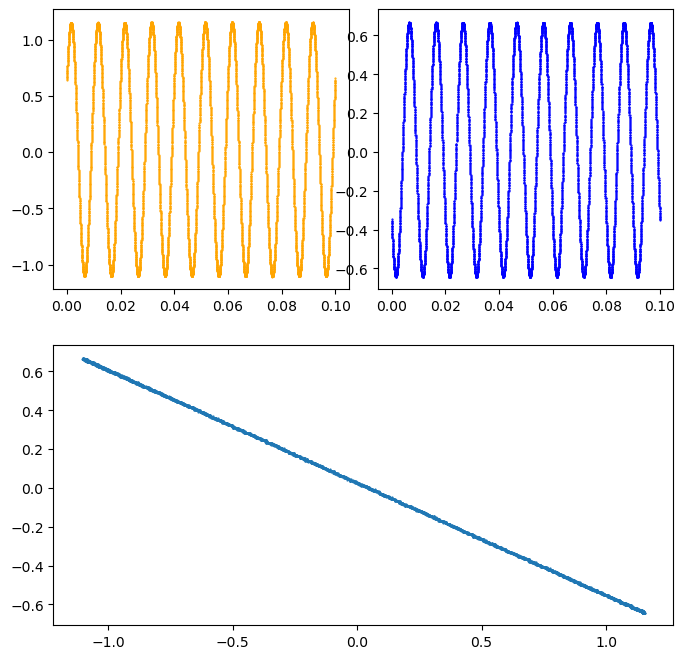

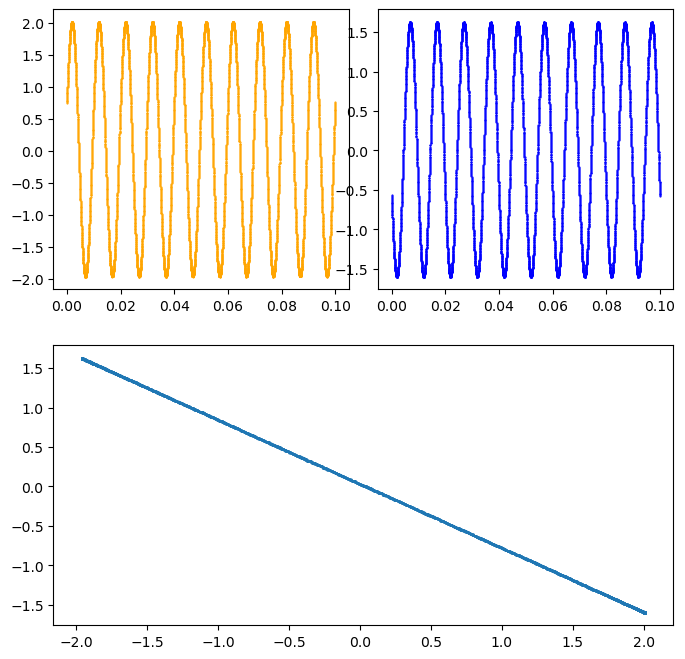

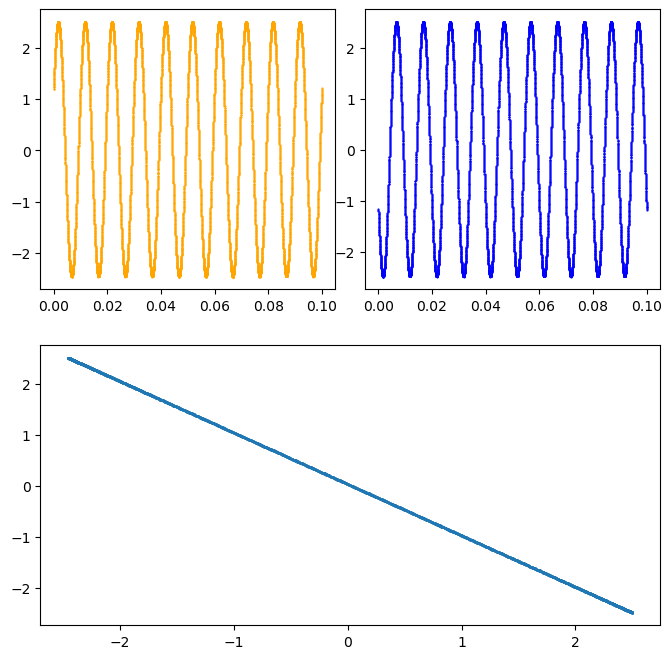

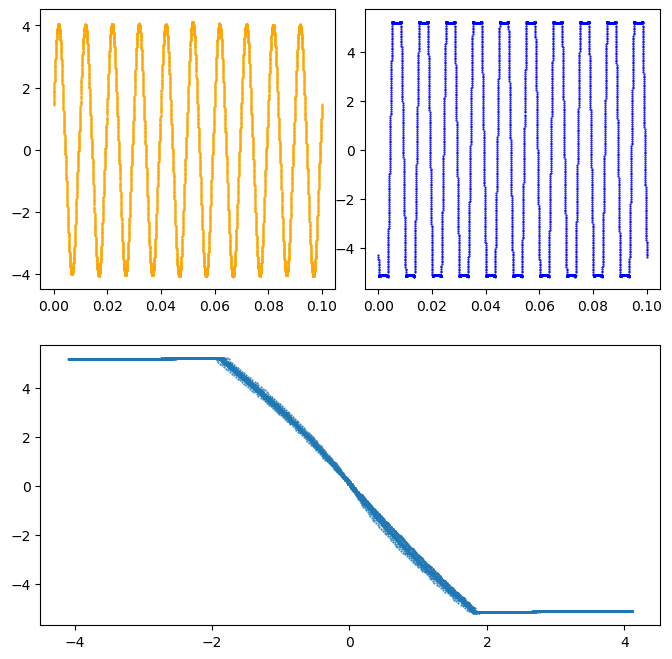

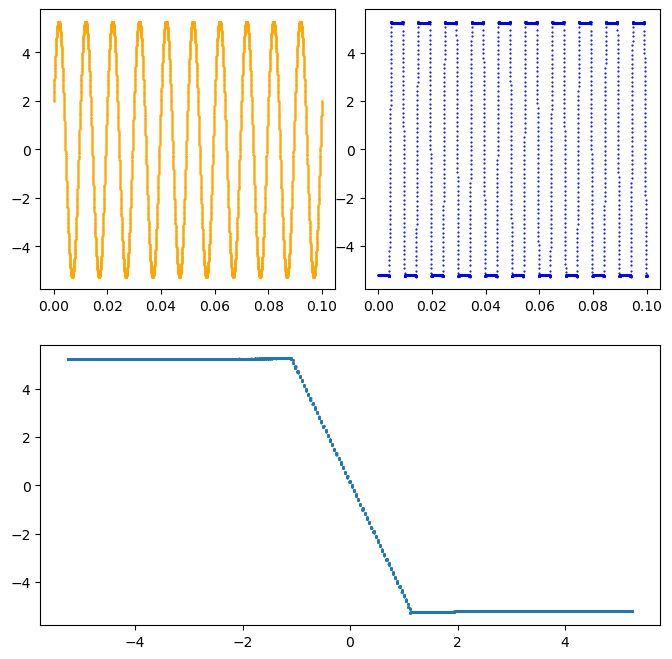

In [79]:
Res1 = 1000 # in Ohms
Res2 = [150,220,330,470,510,800,1000,2000,4700]
data_dict = {"R1": Res1,"R2": Res2}
for R2 in enumerate(Res2): 
    data_dict[R2] = {}

E_sat = 5 # Bias voltage
t_mes = 0.1 # Measurement time

size,rate = sampling(t_mes)
for R2 in Res2: 
    fig = plt.figure(figsize=(8,8))
    grid = gs.GridSpec(2,2,wspace=0.1,)

    axs1 = plt.subplot(grid[0,0])
    axs2 = plt.subplot(grid[0,1])
    axs3 = plt.subplot(grid[1,:])

    v_range = .5*E_sat*R2/Res1
    print(v_range)
    ad2.config_wavegen(zoroku, 
                frequency=10/t_mes,
                amplitude=5,
                offset=0,
                channel = 0,
                signal_shape= dwfc.funcSine
                )

    ad2.config_oscilloscope(zoroku,
        range0=23,
        range1=23,
        sample_rate = rate,
        sample_size= size,
        )

    ad2.start_wavegen(zoroku,channel=0)
    time.sleep(0.1)
    T,Ch1,Ch2 = ad2.measure_oscilloscope(zoroku)
    ad2.stop_wavegen(zoroku,channel=0)
    
    data_dict[R2] = T,Ch1,Ch2

    axs1.scatter(T,Ch1,s=0.3,color="orange")
    axs2.scatter(T,Ch2,s=0.3,color="blue")
    axs3.scatter(Ch1,Ch2,s=0.3)
    fig_name = f"inverting_amp{R2}.png"
    plt.savefig(fig_name)

    handle = open("inverting_amp.pkl", 'wb')
    pickle.dump(data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    handle.close()

    print("Data up to resistor %d has been collected and saved." % R2)
    input("Switch resistor, then press ENTER to measure.")
